
## Brain Region Specific Drug Discovery


###### Executive Summary:

In this capstone project I used web-scraping techniques to cross reference two publically available databases and found **81** proteins that have either been successfully targeted by existing drugs or are the targets of drugs already in clinical trials and that are also that are enriched in a particular brain region.

I went on to perform machine learning on these data and was able to find **60** proteins that are predicted to be the targets of drugs that will pass clinical trials or better.

These findings may be useful to those interested in cheaply developing drugs for brain diseases or disorders that affect specific brain regions or for clinicians treating said disorders, as well as those looking for new drug targets to invest in. 

###### Motivation:

While the brain is a single organ, it is made up of many different regions. These regions are differentially affected by brain diseases and disorders, such as neurodegenerative diseases and psychiatric disorders.

One major challenge in drug development for treatment of brain disease is that drugs lack specificity in terms of the brain region targeted.  To find potential drug targets that have enhanced specificity I focused on proteins from the **The Human Protein Atlas** previously found to be elevated in particular regions of the brain.

###### Data Ingestion:  

I cross referenced regionally elevated proteins from The Human Protein Atlas with known drug targets from the **Therapeutic Target Database**.

1) I scraped the Therapeutic Target Database using requests, BeautifulSoup, and regex. I generated a dataframe that included the Target ID, Uniprot ID, Target Name, and Target Type.

In [11]:
import dill
from IPython import display

drug_database= dill.load(open('drug_database1.pkd', 'rb'))

In [13]:
drug_database.rename(columns={'alternate_uniprot':'uniprot_id'}).head(10)

,target_id,uniprot_id,target_name,target_type
0,T00032,OSTP_HUMAN,Osteopontin (SPP1),Research target
1,T00033,TGFA_HUMAN,Transforming growth factor alpha (TGFA),Clinical Trial target
2,T00037,ERG6_PNEC8,Fungal Sterol 24-C-methyltransferase (Fung erg6),Research target
3,T00039,CTGF_HUMAN,CTGF messenger RNA (CTGF mRNA),Clinical Trial target
4,T00075,MRCKA_HUMAN,CDC42 binding protein kinase alpha (DMPK-like ...,Research target
5,T00088,PIGU_HUMAN,GPI transamidase component PIG-U (PIGU),Research target
6,T00140,LOX5_HUMAN,Arachidonate 5-lipoxygenase (5-LOX),Successful target
7,T00156,TRPC5_HUMAN,Short transient receptor potential channel 5 (...,Clinical Trial target
8,T00176,MDM2_HUMAN,Ubiquitin-protein ligase E3 Mdm2 (MDM2),Clinical Trial target
9,T00238,NFKB2_HUMAN,NFKB messenger RNA (NFKB mRNA),Clinical Trial target


2) I downloaded data from The Human Protein Atlas for each brain region with regionally elevated proteins. I wrote a custom function in order to scrape a third database, **Uniprot**, in order find the same ID type used in the Therapeutic Target data for each protein listed in The Human Protein Atlas data. I combined the data for all brain regions into one dataframe that included the common Uniprot ID type.

In [14]:
def get_alternate_uniprotID(df,col):
    alternate_ids=[]
    for i in range(0,len(df[col])):
        page = requests.get('https://www.uniprot.org/uniprot/'+str(df[col][i]))
        soup = BeautifulSoup(page.text, "lxml")
        span = soup.find("span", property="alternateName")
        alternate_id=re.findall(r'\((.*?)\)',str(span))
        if alternate_id:
            alternate_id=alternate_id[0]
        else: alternate_id= float('nan')
        alternate_ids.append(alternate_id)
    df['alternate_uniprot']=alternate_ids

3) Using these common Uniprot IDs, I generated a dataframe of proteins that exist in both databases. 

4) The 'Protein class' data had no null values in the dataframe and the 'Molecular function' class had only 26 null values, I decided to focus on these data as features for training a model.

5) Target type falls into 5 categories: 'Clinical Trial target', 'Research target', 'Successful target', 'Discontinued target', and 'Patented target'. I binarized these data to be equal to one if the target type was clinical trial target, successful target, or patented target.

6) I removed duplicate values, keeping targets based on the region in which they were the most enriched.

7) I removed all rows with null values.

In [15]:
cleaned_region=dill.load(open('cleaned_region.pkd', 'rb'))

In [16]:
cleaned_region.rename(columns={'alternate_uniprot':'uniprot_id'}).head(10)

,region,target_type,uniprot_id,Protein class,Molecular function,binary_data
132,basalganglia,Successful target,CP17A_HUMAN,"Disease related genes, Enzymes, FDA approved d...","Lyase, Monooxygenase, Oxidoreductase",1
230,pons,Successful target,CSF3_HUMAN,"Cancer-related genes, Plasma proteins, Predict...","Cytokine, Growth factor",1
232,pons,Patented target,PAR2_HUMAN,"G-protein coupled receptors, Predicted membran...","G-protein coupled receptor, Receptor, Transducer",1
203,pons,Successful target,HPPD_HUMAN,"Disease related genes, Enzymes, FDA approved d...","Dioxygenase, Oxidoreductase",1
25,hypothalamus,Research target,GBRE_HUMAN,"FDA approved drug targets, Predicted membrane ...","Chloride channel, Ion channel",0
116,amygdala,Research target,GBRR1_HUMAN,"FDA approved drug targets, Predicted membrane ...","Chloride channel, Ion channel",0
67,cerebellum,Research target,SOCS1_HUMAN,"Cancer-related genes, Predicted intracellular ...",Signal transduction inhibitor,0
147,basalganglia,Successful target,NR1I3_HUMAN,"Nuclear receptors, Predicted intracellular pro...","Activator, DNA-binding, Receptor",1
166,olfactory,Successful target,GLP2R_HUMAN,"FDA approved drug targets, G-protein coupled r...","G-protein coupled receptor, Receptor, Transducer",1
3,hypothalamus,Research target,NEU2_HUMAN,"Disease related genes, Predicted secreted prot...","Hormone, Vasoactive, Vasoconstrictor",0


5) I generated a second dataframe of regionally elevated proteins that do not exist in the Therapeutic Target Database.

In [17]:
pred_correct=dill.load(open('pred_correct.pkd', 'rb'))

In [18]:
pred_correct.rename(columns={'alternate_uniprot':'uniprot_id'}).head(10)

,region,uniprot_id,Protein class,Molecular function
181,pons,CORIN_HUMAN,"Disease related genes, Enzymes, Plasma protein...","Hydrolase, Protease, Serine protease"
97,cerebellum,PP13_HUMAN,Predicted intracellular proteins,Hemagglutinin
278,cerebellum,MTG8_HUMAN,"Cancer-related genes, Disease related genes, P...","DNA-binding, Repressor"
61,pons,SLPI_HUMAN,"Cancer-related genes, Plasma proteins, Predict...","Antibiotic, Antimicrobial, Protease inhibitor,..."
176,cerebellum,FOXE3_HUMAN,"Disease related genes, Predicted intracellular...",DNA-binding
53,amygdala,PTER_HUMAN,Predicted intracellular proteins,Hydrolase
8,olfactory,NEUG_HUMAN,Predicted intracellular proteins,Calmodulin-binding
27,cerebellum,NDF1_HUMAN,"Disease related genes, Predicted intracellular...","Activator, Developmental protein, DNA-binding"
137,basalganglia,PTN7_HUMAN,"Enzymes, Predicted intracellular proteins","Hydrolase, Protein phosphatase"
162,pons,SYNE2_HUMAN,"Disease related genes, Plasma proteins, Predic...",Actin-binding


###### First Result

I found **81** regionally enhanced proteins that have either been successfully targeted by existing drugs or are the targets of drugs already in clinical trials.  

These targets are potential candidates for the treatments of disorders that effect specific brain regions. Those not already used  to treat these types of disorders represent viable candidates that can be marketed without the cost of developing a research projects or clinical trials to verify that they are safe for human use.

###### Machine Learning:

While these successful and clinical targets are useful, we are left with about 300 proteins that do not fall into these categories.  These left over regionally enhanced proteins also have potential value, but which should be invested in for drug development?

In order to predict which should be focused on I used **sci-kit learn** to train a **Decision Tree Classifier** on the regionally enhanced proteins that were cross referenced in the Therapeutic Target Database.

I trained the model using 80% of the data, and I padded the training data with duplicates to create a balanced training data set. 

I generated dummy columns for each Protein class and Molecular function that existed for both the cross-referenced and unreferenced proteins.  These were the features I trained the model on.  The labels to predict from these features were the binarized drug statuses I previously derived (see binary target column above). I removed features related to drug development or disease in order to learn if aspects of the proteins themselves are important for their success as drug targets.

I performed **cross validation** using **sklearn.model_selection.GridSearchCV** to find the best value for the hyperparameter max depth.  I fit 10 folds for each of 100 candidates (ranging from 0 to 1) totalling 1000 fits. 

**The best max depth value was 10.**

The mean accuracy on the given training data and labels was 0.87.

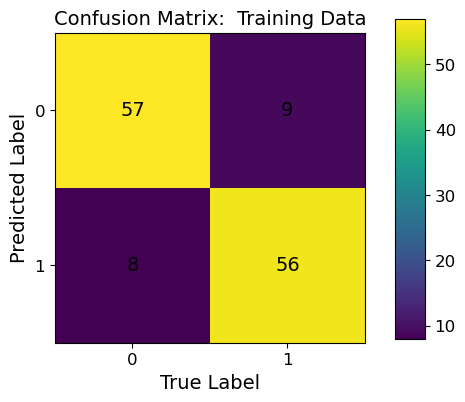

In [19]:
display.Image('train_cm.png')

**The mean accuracy on the given test data and labels was 0.76.**

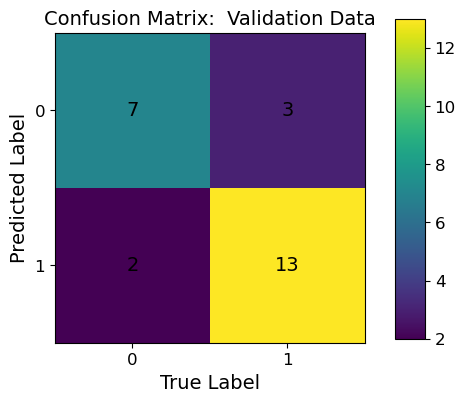

In [20]:
display.Image('test_cm.png')

###### Second Result

I then used the fitted model to predict on the proteins not referenced in the Therapeutic Target Database.

**It predicted 60 proteins to be targets of drugs that would proceed to clinical trials or better.**

These hits are proteins that are likely to be successfully developed as drug targets based on their protein class and molecular function, and thus are targets that companies may want to invest resources in (to develop research trials or clinical trials).

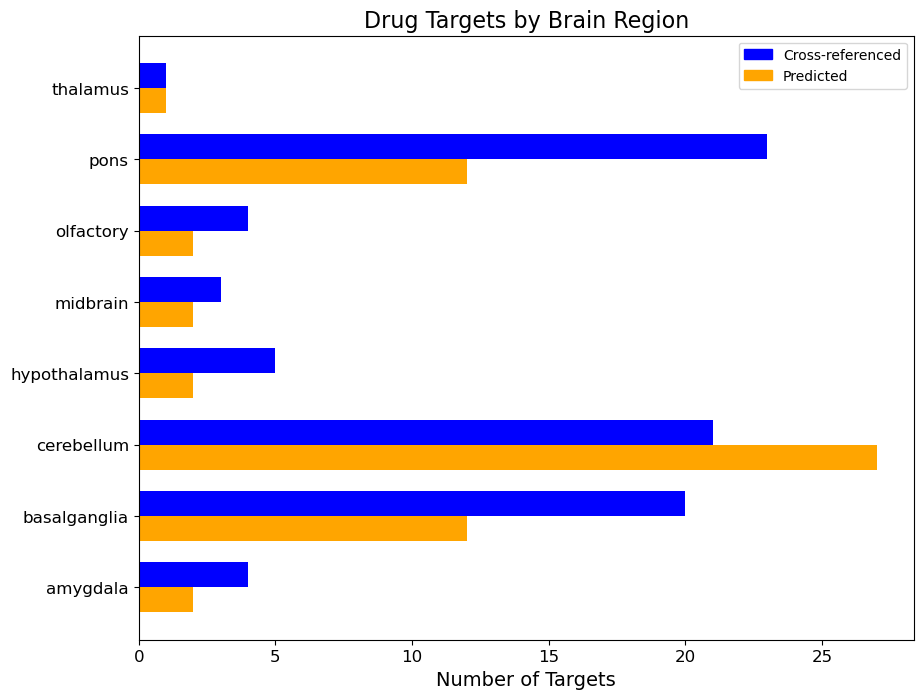

In [21]:
display.Image('region_targets.png')

The predicted targets are listed in the dataframe below, organized by region.

In [29]:
new_targets=dill.load(open('new_targets_125.pkd', 'rb'))

In [30]:
new_targets

,region,uniprot_id
0,amygdala,P2RX2_HUMAN
1,amygdala,CCG8_HUMAN
2,basalganglia,LOXE3_HUMAN
3,basalganglia,PNDC1_HUMAN
4,basalganglia,GPR52_HUMAN
5,basalganglia,PDYN_HUMAN
6,basalganglia,CCG3_HUMAN
7,basalganglia,GPR6_HUMAN
8,basalganglia,PENK_HUMAN
9,basalganglia,RXFP2_HUMAN


I was interested in which protein classes and molecular features were most important to the model, based on permutating through shuffled features.  

Interestingly, whether or not a target is a receptor was the most important feature, with a mean decrease in accuracy of about 30%.  This may suggest receptors in the previous dataframe are good research investments.

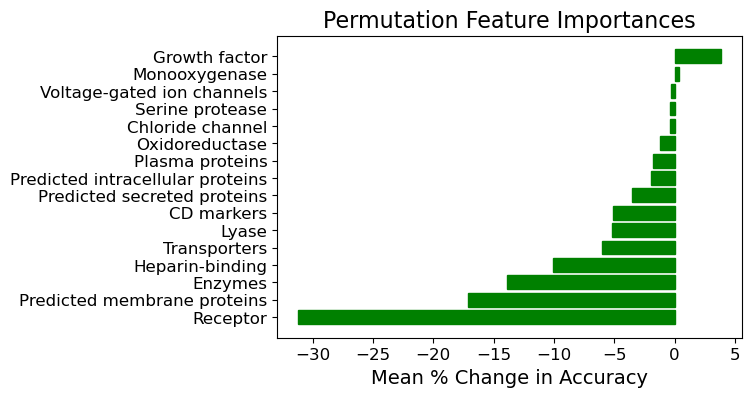

In [24]:
display.Image('feature_importance_permutations.png')

###### Citations:

https://www.proteinatlas.org/humanproteome/brain

https://www.uniprot.org/

Fagerberg L et al., Analysis of the human tissue-specific expression by genome-wide integration of transcriptomics and antibody-based proteomics. Mol Cell Proteomics. (2014)
PubMed: 24309898 DOI: 10.1074/mcp.M113.035600

Sjöstedt E et al., An atlas of the protein-coding genes in the human, pig, and mouse brain. Science. (2020)
PubMed: 32139519 DOI: 10.1126/science.aay5947

Sjöstedt E et al., Defining the Human Brain Proteome Using Transcriptomics and Antibody-Based Profiling with a Focus on the Cerebral Cortex. PLoS One. (2015)
PubMed: 26076492 DOI: 10.1371/journal.pone.0130028

Uhlén M et al., Tissue-based map of the human proteome. Science (2015)
PubMed: 25613900 DOI: 10.1126/science.1260419

Yu NY et al., Complementing tissue characterization by integrating transcriptome profiling from the Human Protein Atlas and from the FANTOM5 consortium. Nucleic Acids Res. (2015)
PubMed: 26117540 DOI: 10.1093/nar/gkv608

Zhou Y et al., Therapeutic target database update 2022: facilitating drug discovery with enriched comparative data of targeted agents. Nucleic Acids Research. doi:10.1093/nar/gkab953. PMID: 34718717